In [1]:
import os, fiona, glob
import geopandas as gpd
import pandas as pd
from rasterio.crs import CRS
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import shapely
import matplotlib.pyplot as plt

In [2]:
# Every time you change something within the code cell, run it once more to update the variable.

BOUNDS = [39.7299, -77.5886, 36.9909, -81.6319] # In decimal coordinate form.  Format: [N, E, S, W].  Select the smallest area possible in your analyses for maximum resoultion!  

API_KEY = '9086887f175d33aa72eda767f5b1e9cd' # Get your API key from opentopography.org.  Students get higher resolution data!

DEM_DATASET = 'USGS30m' # Options are USGS30m, USGS10m, & USGS1m.  Be warned!  As resolution goes up, available download area goes down.

PROJ_TITLE = 'wv_tot' # Create a succinct name with no spaces or leading digits to represent your project file for future exports.

PATH = os.getcwd()

In [3]:
# Import all files from wv GDB.  
dir = f'{PATH}/{PROJ_TITLE}/GeoDatabases'
path_list = glob.glob(f'{dir}/*.zip')
master_dip_gdf = gpd.GeoDataFrame()
master_geol_gdf = gpd.GeoDataFrame()
for path in path_list:
    try:
        layers = fiona.listlayers(path)
        for layer in layers:
            if 'bed' in layer.lower():
                dip_gdf = gpd.read_file(path, layer=layer)
                dip_gdf.columns = [x.lower() for x in dip_gdf.columns]
                master_dip_gdf = pd.concat([master_dip_gdf, dip_gdf], ignore_index=True)
            elif 'cnt_poly' in layer.lower():
                geol_gdf = gpd.read_file(path, layer=layer)
                geol_gdf.columns = [x.lower() for x in geol_gdf.columns]
                master_geol_gdf= pd.concat([master_geol_gdf, geol_gdf], ignore_index=True)
    except Exception as e:
        pass

master_dip_gdf = master_dip_gdf[['dip_angle', 'dip_direct', 'geometry']].drop_duplicates(subset = ['geometry'], keep='first').to_crs(CRS.from_epsg(2283))
master_geol_gdf = master_geol_gdf[['unit_abbrv', 'geometry']].to_crs(CRS.from_epsg(2283))

In [4]:
from pyproj import Proj, transform
import numpy as np

kp_strat_fin = []

ksn_paths = glob.glob(f'{PATH}/{PROJ_TITLE}/lsht_kps/*.csv')
for csv in ksn_paths:
    csv_name = csv.split(sep='/')[-1]
    wshed_name = csv_name[0:-13]
    ksn_df = pd.read_csv(csv, index_col=0)[['x','y','longitude','latitude','wshed','delta_ksn','elevation']]
    kp_df = gpd.GeoDataFrame(data=ksn_df, geometry= gpd.points_from_xy(ksn_df.x, ksn_df.y), crs=CRS.from_epsg(2283))
    kp_dip = gpd.sjoin_nearest(master_dip_gdf, kp_df, max_distance=300, distance_col='dist_from_dip')
    if len(kp_dip) != 0:
        kp_dip = kp_dip.drop(columns=['index_right'])
        kp_strat = gpd.sjoin(left_df=kp_dip, right_df=master_geol_gdf, how='inner')
        kp_strat_fin.append(kp_strat)

South_Fork_South_Branch_Potomac_River\
Sleepy_Creek

In [5]:
for_graphing = []
for df in kp_strat_fin:
    if len(df) > 10:
        for_graphing.append(df)

In [6]:
t1 = for_graphing[0]
dip_data = t1.dip_angle
dip_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90] # Define bin edges
dip_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'] # Optional labels for bins

elev_data = t1.elevation

binned_elev = pd.cut(elev_data, bins = np.arange(round(elev_data.min()-10, -1), round(elev_data.max()+30, -1), step=20))

binned_dips = pd.cut(dip_data, bins=dip_bins, labels=dip_labels, right=True)

t1['dip_bin'] = binned_dips
t1['elev_bin'] = binned_elev
print([str(t1.groupby('elev_bin').count().index[i]) for i in range(0,len(t1.groupby('elev_bin')))])

['(110.0, 130.0]', '(130.0, 150.0]', '(150.0, 170.0]', '(170.0, 190.0]', '(190.0, 210.0]', '(210.0, 230.0]', '(230.0, 250.0]', '(250.0, 270.0]', '(270.0, 290.0]', '(290.0, 310.0]', '(310.0, 330.0]', '(330.0, 350.0]', '(350.0, 370.0]', '(370.0, 390.0]', '(390.0, 410.0]', '(410.0, 430.0]', '(430.0, 450.0]']


In [7]:
data_by_geol = pd.DataFrame(columns = ['Unit', '0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'])
for x in t1.unit_abbrv.unique():
    bin_count = t1[t1.unit_abbrv == x].groupby('dip_bin').size().values
    new_row = pd.DataFrame([x]+list(bin_count)).T
    new_row.columns = ['Unit', '0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90']
    data_by_geol = pd.concat([data_by_geol, new_row])
data_by_geol

,Unit,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90
0,Mps,1,1,1,0,0,0,1,0,0
0,Dhs,0,0,2,4,0,1,0,0,0
0,Mpr,1,0,0,0,0,0,0,0,0
0,Dch,0,1,0,2,4,3,4,1,0
0,Mm,0,0,1,1,0,0,1,0,0
0,Mpk,0,0,0,1,0,0,0,0,0
0,Dbh,0,1,0,1,1,1,1,2,0
0,Sb,0,0,0,1,0,0,0,0,1
0,Dmt,1,0,3,2,2,1,0,2,0
0,St,0,0,1,0,0,0,0,0,0


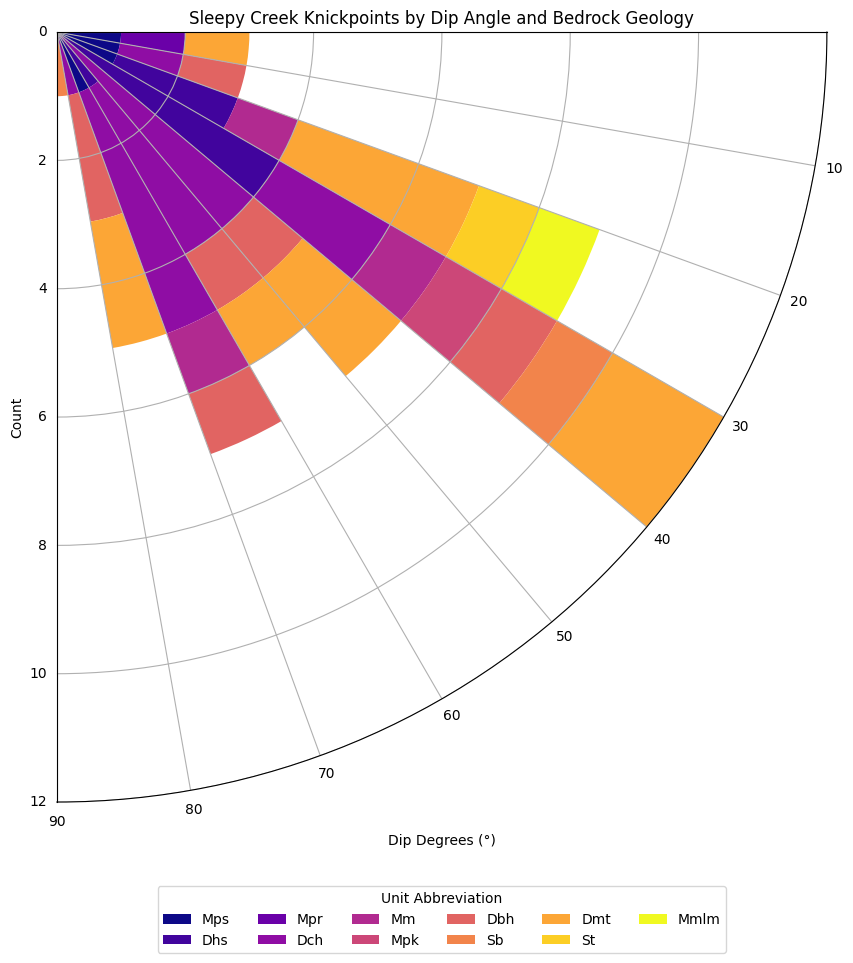

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))

num_discrete_levels = len(data_by_geol)
discrete_cmap = plt.cm.get_cmap('plasma', num_discrete_levels)

ax = fig.add_subplot(111, polar=True)
ax.set_thetamin(270)
ax.set_thetamax(360)
labels = labels = np.flip(['10', '20', '30', '40', '50', '60', '70', '80', '90'])
perim = -np.pi/2
width = (2*np.pi/36)
start_point = (perim-.5*width)
theta = np.arange(width/2, np.abs(start_point), step = width)
theta = [number * -1 for number in theta]
ax.set_xticklabels(labels)
bottom = 0
for i in range(0, len(data_by_geol)):
    if i==0:
        ax.bar(theta, data_by_geol.iloc[i][1:].values, width = width, label = data_by_geol.iloc[i][0], color = discrete_cmap.colors[i])
        bottom = data_by_geol.iloc[0][1:].values
    else:
        ax.bar(theta, data_by_geol.iloc[i][1:].values, width = width, bottom = bottom, label = data_by_geol.iloc[i][0], color = discrete_cmap.colors[i])
        bottom += data_by_geol.iloc[i][1:].values

ax.set_title('Sleepy Creek Knickpoints by Dip Angle and Bedrock Geology')
ax.set_xlabel('Dip Degrees (°)')
ax.set_ylabel('Count')

plt.legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5,-.1), title='Unit Abbreviation')
plt.show()
plt.close()

# Now by elevation

In [13]:
data_by_elev = pd.DataFrame(columns = ['elev_bin', '0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'])
for x in sorted(t1.elev_bin.unique()):
    bin_count = t1[t1.elev_bin == x].groupby('dip_bin').size().values
    new_row = pd.DataFrame([x]+list(bin_count)).T
    new_row.columns = ['elev_bin', '0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90']
    data_by_elev = pd.concat([data_by_elev, new_row])
data_by_elev

,elev_bin,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90
0,"(110.0, 130.0]",0,0,0,0,0,0,1,0,0
0,"(130.0, 150.0]",0,0,0,0,0,0,1,1,0
0,"(150.0, 170.0]",0,0,2,1,1,0,0,0,0
0,"(170.0, 190.0]",0,0,0,1,1,1,1,0,0
0,"(190.0, 210.0]",1,1,0,1,0,1,0,0,0
0,"(210.0, 230.0]",0,1,0,2,1,2,0,0,0
0,"(230.0, 250.0]",1,1,2,4,3,2,2,0,0
0,"(250.0, 270.0]",0,0,2,0,0,0,0,2,0
0,"(270.0, 290.0]",0,0,0,1,1,0,0,2,1
0,"(290.0, 310.0]",1,0,0,0,0,0,0,0,0


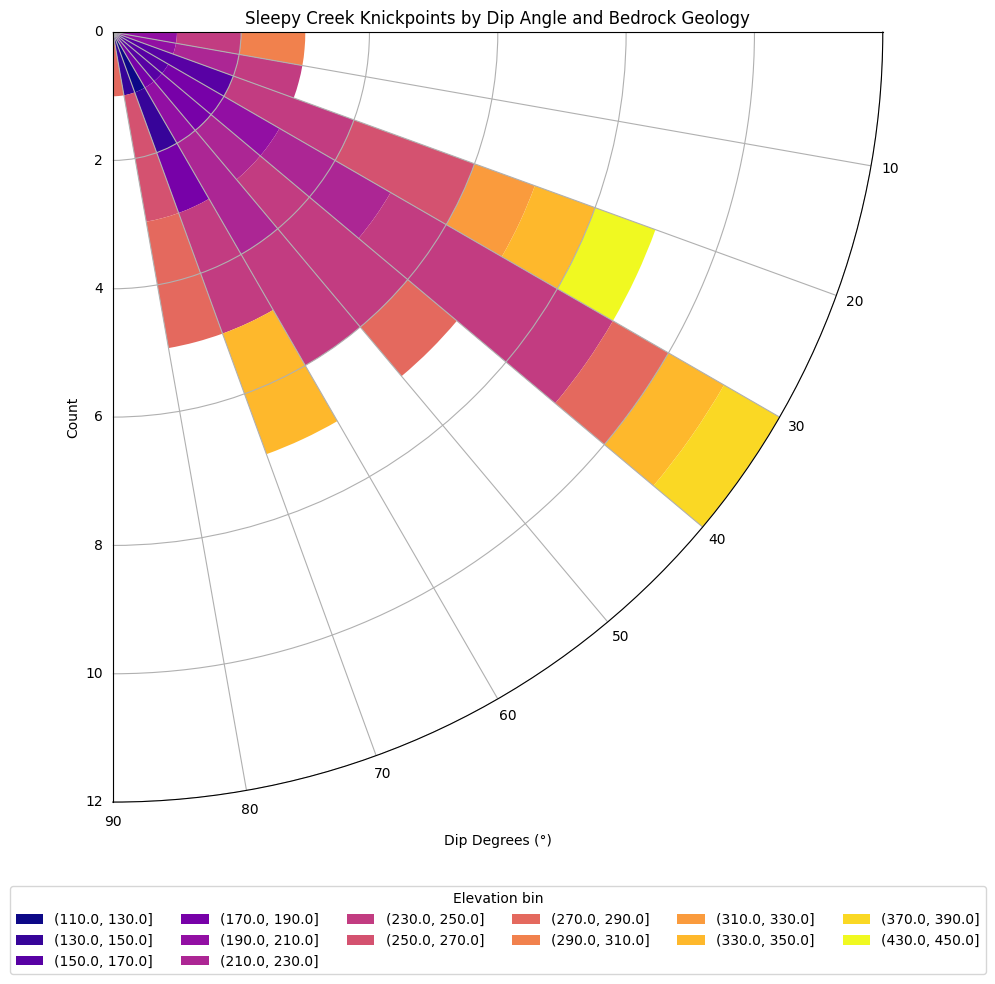

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))

num_discrete_levels = len(data_by_elev)
discrete_cmap = plt.cm.get_cmap('plasma', num_discrete_levels)

ax = fig.add_subplot(111, polar=True)
ax.set_thetamin(270)
ax.set_thetamax(360)
labels = labels = np.flip(['10', '20', '30', '40', '50', '60', '70', '80', '90'])
perim = -np.pi/2
width = (2*np.pi/36)
start_point = (perim-.5*width)
theta = np.arange(width/2, np.abs(start_point), step = width)
theta = [number * -1 for number in theta]
ax.set_xticklabels(labels)
bottom = 0
for i in range(0, len(data_by_elev)):
    if i==0:
        ax.bar(theta, data_by_elev.iloc[i][1:].values, width = width, label = data_by_elev.iloc[i][0], color = discrete_cmap.colors[i])
        bottom = data_by_elev.iloc[0][1:].values
    else:
        ax.bar(theta, data_by_elev.iloc[i][1:].values, width = width, bottom = bottom, label = data_by_elev.iloc[i][0], color = discrete_cmap.colors[i])
        bottom += data_by_elev.iloc[i][1:].values

ax.set_title('Sleepy Creek Knickpoints by Dip Angle and Bedrock Geology')
ax.set_xlabel('Dip Degrees (°)')
ax.set_ylabel('Count')

plt.legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5,-.1), title='Elevation bin')
plt.show()
plt.close()

In [9]:
# Made a table for ppt.
names=[]
count=[]
for df in kp_strat_fin:
    names.append(df.wshed.values[0])
    count.append(len(df))
dic = pd.DataFrame(data=[names, count]).T
dic.columns = ['Watershed Name', 'Knickpoints with dip and geol data']
display(dic)

,Watershed Name,Knickpoints with dip and geol data
0,Savage_River,1
1,Stony_River-North_Branch_Potomac_River,2
2,Trading_Run-North_Branch_Potomac_River,1
3,Patterson_Creek,2
4,New_Creek-North_Branch_Potomac_River,3
5,Sleepy_Creek,53
6,Back_Creek,22
7,North_Fork_South_Branch_Potomac_River,13
8,Upper_South_Branch_Potomac_River,23
9,South_Fork_South_Branch_Potomac_River,31
